In [2]:
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import re
import os
import pickle
import string
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
import keras
import tensorflow as tf
from tqdm import tqdm
from vncorenlp import VnCoreNLP
from pyvi import ViTokenizer, ViUtils
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras import Sequential
from tensorflow.keras.constraints import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers.merge import concatenate

In [4]:
#Path to VNCoreNLP jar file
rdrsegmenter_path = '/content/drive/MyDrive/Colab/ThanhDat/Library/vncorenlp/VnCoreNLP-1.1.1.jar'

In [ ]:
# Define some necessary function
annotator = VnCoreNLP(rdrsegmenter_path, annotators="wseg", max_heap_size='-Xmx500m')
stopwords =['comments', 'recent', 'all', 'da ban', 'top', 'most', 'all', 'comment', 'like', 'share']
def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'bit.ly/\S+', '', text)
    text = text.strip('[link]')
    return text 
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
def remove_special_characters(text):
    RE_HTML_TAG = re.compile(r'<[^>]+>')
    DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'
    text = re.sub(r'\n', ' ', text)
    text = re.sub(RE_HTML_TAG, ' ', text)
    text = re.sub(DATETIME, ' ', text)
    return text
def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in stopwords]) 
def remove_number(text):
    return " ".join([word for word in str(text).split() if not containsNumber(word)])
def check_dict(dictionary, text):
  result = []
  for token in text.split():
    if token in dictionary:
      result.append(token)
  return ' '.join(result)
def pre_process(text):
      text = remove_links(text)
      text = remove_punctuation(text)
      text = remove_special_characters(text)
      text = remove_number(text)
      # try:
      #   text = ViUtils.add_accents(text)
      # except: 
      #   pass 
      text = text.lower()
      text = remove_stopword(text)
      # text = check_dict(vietDict, text)
      text = " ".join([" ".join(i) for i in annotator.tokenize(text)])
      return text
def to_tensor(x):
  return np.asarray(x).astype('float32')
def encoding(text):
  result = []
  for i in text.split():
    try:
      result.append(dictToken[i])
    except:
      result.append(0)
  return result
def split_data(dataframe):
  train, val = train_test_split(dataframe[['padded', 'one_hot_labels']], test_size = 0.1)
  return train, val
def process_trainable_data(dataframe):
  X = np.array(dataframe['padded'].tolist())
  y = np.array(dataframe['one_hot_labels'].tolist())
  return X, y

import datetime

def create_checkpoint(model_name):
  root_dir = '/content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint'
  time = str(datetime.datetime.now()).split('.')[0]
  name_ckpt = model_name + '_' + time
  return ModelCheckpoint(
    filepath = os.path.join(root_dir, name_ckpt),
    monitor = 'val_f1',
    save_best_only = True,
    save_weights_only = False,
    verbose = 1,
    mode = 'max')

In [ ]:
#Load dataset to DataFrame
rootdir = 'path/to/directory'
data_path = os.path.join(rootdir,'dataset_social')
df = pd.DataFrame(columns = ['contents', 'labels'])
reassign_label = []
i = 0
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    reassign_label.append([i,file])
    for name in os.listdir(d):
      try:
        dfx = pd.read_csv(str(os.path.join(d, name))).iloc[:,-1]
        dfx = pd.DataFrame(dfx.to_list(), columns = ['contents'])
        dfx['labels'] = [i]*len(dfx)
        df = pd.concat([df,dfx])
      except:
        pass
    i+=1

In [ ]:
df = df[df['contents'].apply(lambda x: len(str(x)) >= 10)]
df = df.dropna()
df = df.reset_index(drop = True)
df = df.astype({'labels':'int'})
tqdm.pandas()
# Pre-process data: lower, remove punctuation, word segmentation,...
df['news'] = df['contents'].progress_apply(lambda x: pre_process(x))

## Make some EDA

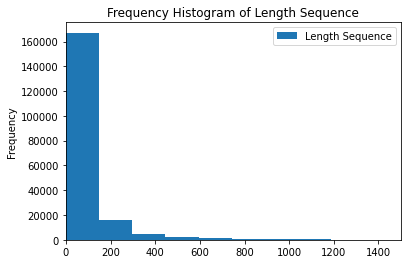

In [ ]:
length_sen = [len(sen.split()) for sen in df['news']]

plt.hist(length_sen, label='Length Sequence', bins=50)
plt.gca().set(title='Frequency Histogram of Length Sequence', ylabel='Frequency')
plt.xlim(0,1500)
plt.legend()

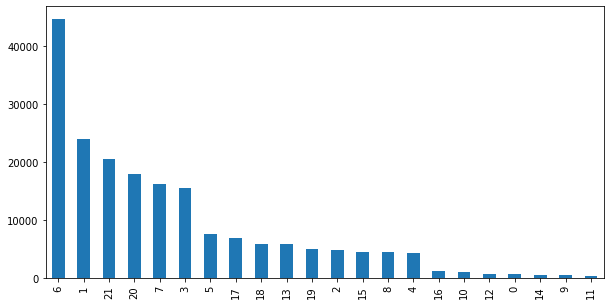

In [9]:
df['labels'].value_counts().plot(kind="bar", figsize=(10,5))

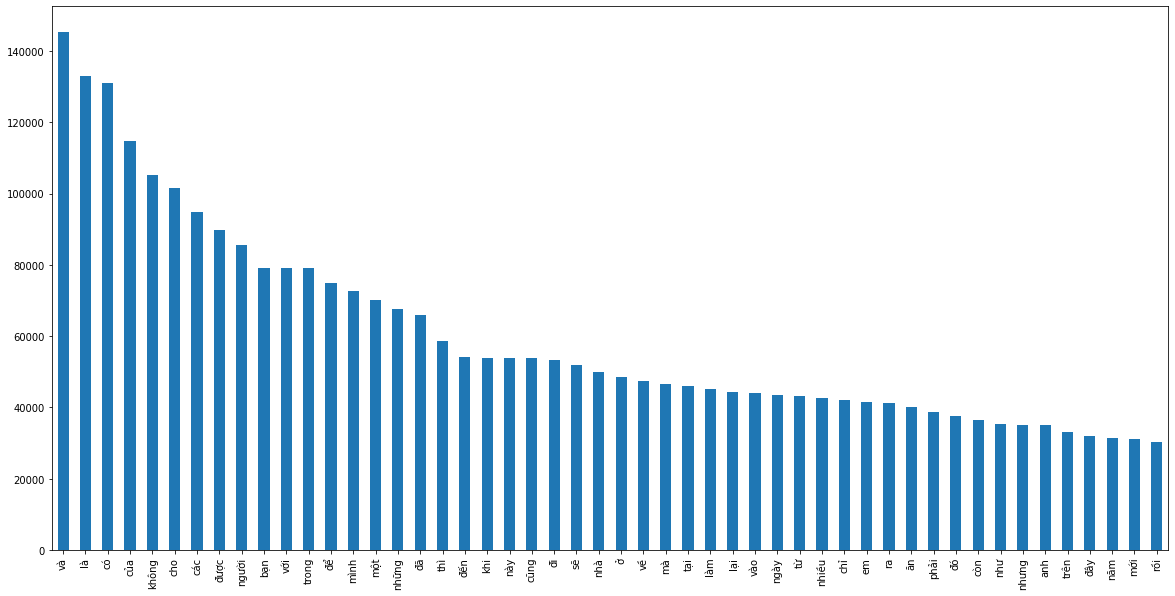

In [13]:
pd.Series(' '.join(df.news).split()).value_counts()[:50].plot(kind="bar", figsize=(20,10))

In [14]:
#Take fifty most frequency words are stopword
stopwords = pd.Series(' '.join(df.news).split()).value_counts()[:50].keys().to_list()
tqdm.pandas()
df['news'] = df['news'].progress_apply(lambda x: remove_stopword(x))
#After removing top 50 frequency words
pd.Series(' '.join(df.news).split()).value_counts()[:50].plot(kind="bar", figsize=(20,10))

Encoding, Split data to train

In [17]:
dictText = []
for text in df['news']:
  dictText += text.split()
dictText = list(set(dictText))
dictToken = dict()
for i in range(len(dictText)):
  dictToken[dictText[i]] = i
df['encode'] = df['news'].progress_apply(lambda x: encoding(x))
encode = df['encode'].tolist()
padded = pad_sequences(encode, maxlen = 300, dtype = 'float32', truncating = 'post', padding = 'post')
df['padded'] = padded.tolist()
le = OneHotEncoder()
label_en = le.fit_transform([[i] for i in df['labels'].tolist()])
df['one_hot_labels'] = label_en.toarray().tolist()

In [18]:
train, val = train_test_split(df[['padded', 'labels']], test_size = 0.1)
vocab = len(dictToken) + 1
X_train, y_train = process_trainable_data(train)
X_val, y_val = process_trainable_data(val)

100%|██████████| 144680/144680 [00:04<00:00, 33656.16it/s]


Loading Embedding matrix

In [28]:
path_to_word2vec = '/content/drive/MyDrive/Colab/ThanhDat/Text Classification/Data_BDS/word2vec_vi_words_100dims.txt'
embeddings_index = {}
with open(path_to_word2vec) as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 1585092 word vectors.


In [29]:
num_tokens = vocab + 1
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in dictToken.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 48267 words (134807 misses)


Custom metrics F1-score

In [30]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


def fbeta(y_true, y_pred, beta=2):
    y_pred = K.clip(y_pred, 0, 1)

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    num = (1 + beta ** 2) * (p * r)
    den = (beta ** 2 * p + r + K.epsilon())
    return K.mean(num / den)


def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())


def equal_error_rate(y_true, y_pred):
    n_imp = tf.count_nonzero(tf.equal(y_true, 0), dtype=tf.float32) + tf.constant(K.epsilon())
    n_gen = tf.count_nonzero(tf.equal(y_true, 1), dtype=tf.float32) + tf.constant(K.epsilon())

    scores_imp = tf.boolean_mask(y_pred, tf.equal(y_true, 0))
    scores_gen = tf.boolean_mask(y_pred, tf.equal(y_true, 1))

    loop_vars = (tf.constant(0.0), tf.constant(1.0), tf.constant(0.0))
    cond = lambda t, fpr, fnr: tf.greater_equal(fpr, fnr)
    body = lambda t, fpr, fnr: (
        t + 0.001,
        tf.divide(tf.count_nonzero(tf.greater_equal(scores_imp, t), dtype=tf.float32), n_imp),
        tf.divide(tf.count_nonzero(tf.less(scores_gen, t), dtype=tf.float32), n_gen)
    )
    t, fpr, fnr = tf.while_loop(cond, body, loop_vars, back_prop=False)
    eer = (fpr + fnr) / 2

    return eer

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

Crate model and some config

In [32]:
num_vocab = vocab
max_length = X_train.shape[1]
batch_size = 64
epoch = 100

In [33]:
# Best-score model
def build_BiLSTM_model():
  model = Sequential()
  model.add(Embedding(num_tokens, embedding_dim, 
                      embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                      input_length = max_length, trainable = True)) #input_length = max_length
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256)))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(22, activation='softmax'))
  return model 

In [34]:
model = build_BiLSTM_model()
model.compile(optimizer = Adam(1e-4), loss = 'categorical_crossentropy', metrics = [f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          18307600  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 1024)        1886208   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1969152   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [35]:
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),
          batch_size = 32,
          epochs = 20,
          verbose = 1
          )

Epoch 1/100
4070/4070 [==============================] - ETA: 0s - loss: 1.7919 - f1: 0.3580
Epoch 1: val_f1 improved from -inf to 0.52433, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/the_best_model_ver15-6.h5
4070/4070 [==============================] - 640s 155ms/step - loss: 1.7919 - f1: 0.3580 - val_loss: 1.3911 - val_f1: 0.5243
Epoch 2/100
4070/4070 [==============================] - ETA: 0s - loss: 1.2631 - f1: 0.5624
Epoch 2: val_f1 improved from 0.52433 to 0.58421, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/the_best_model_ver15-6.h5
4070/4070 [==============================] - 611s 150ms/step - loss: 1.2631 - f1: 0.5624 - val_loss: 1.2046 - val_f1: 0.5842
Epoch 3/100
4070/4070 [==============================] - ETA: 0s - loss: 1.0439 - f1: 0.6373
Epoch 3: val_f1 improved from 0.58421 to 0.61584, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/the_best_model_ver15-6.h5
4070/4070 [=============

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/the_best_model_ver15-6.h5', custom_objects={"f1": f1})

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          21999500  
                                                                 
 bidirectional (Bidirectiona  (None, 400, 1024)        1886208   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1969152   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
num_vocab = vocab
max_length = X_train.shape[1]
batch_size = 64
epoch = 100

In [ ]:
def ensemble_CNN_BiGRU(filters = 100, kernel_size = 3, activation='relu', 
                   input_dim = None, output_dim=None, max_length = None, emb_matrix = None):
  
    # Channel 1D CNN
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(input_dim=input_dim, 
                            output_dim=output_dim, 
                            input_length=max_length, 
                            input_shape=(max_length, ),
                            # Assign the embedding weight with word2vec embedding marix
                            weights = [emb_matrix],
                            # Set the weight to be not trainable (static)
                            trainable = True)(input1)
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                   kernel_constraint= MaxNorm( max_value=3, axis=[0,1]))(embeddding1)
    pool1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(64, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(22, activation='softmax')(drop1)
    
    # Channel BiGRU
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(input_dim=input_dim, 
                            output_dim=output_dim, 
                            input_length=max_length, 
                            input_shape=(max_length, ),
                            # Assign the embedding weight with word2vec embedding marix
                            weights = [emb_matrix],
                            # Set the weight to be not trainable (static)
                            trainable = True,
                            mask_zero=True)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(22, activation='softmax')(drop2)
    
    # Merge
    merged = concatenate([out1, out2])
    
    # Interpretation
    outputs = Dense(22, activation='softmax')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)
    print(model.summary())
    # Compile
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1])
    
    return model

In [ ]:
model_CNN_BiGRU = ensemble_CNN_BiGRU(input_dim=num_tokens, output_dim=embedding_dim, max_length=max_length, emb_matrix=embedding_matrix)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 100)     21999500    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 398, 100)     30100       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 199, 100)     0           ['conv1d[0][0]']                 
                                                                                              

In [ ]:
model_CNN_BiGRU.fit(x=[X_train,X_train], y=y_train, 
                    validation_data=([X_val,X_val],y_val),
                    batch_size = batch_size,
                    epochs = epoch,
                    callbacks = create_checkpoint("CNN_BiGRU"))

Epoch 1/100
2722/2723 [============================>.] - ETA: 0s - loss: 2.2891 - acc: 0.3090 - f1: 0.0672
Epoch 1: val_f1 improved from -inf to 0.15986, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 514s 182ms/step - loss: 2.2890 - acc: 0.3090 - f1: 0.0673 - val_loss: 1.9032 - val_acc: 0.3943 - val_f1: 0.1599
Epoch 2/100
2722/2723 [============================>.] - ETA: 0s - loss: 1.6680 - acc: 0.4694 - f1: 0.3491
Epoch 2: val_f1 improved from 0.15986 to 0.44483, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 498s 183ms/step - loss: 1.6680 - acc: 0.4694 - f1: 0.3491 - val_loss: 1.5068 - val_acc: 0.5283 - val_f1: 0.4448
Epoch 3/100
2722/2723 [============================>.] - ETA: 0s - loss: 1.2585 - acc: 0.6135 - f1: 0.5316
Epoch 3: val_f1 improved from 0.44483 to 0.53366, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 500s 184ms/step - loss: 1.2584 - acc: 0.6135 - f1: 0.5316 - val_loss: 1.2890 - val_acc: 0.5911 - val_f1: 0.5337
Epoch 4/100
2722/2723 [============================>.] - ETA: 0s - loss: 1.0302 - acc: 0.6762 - f1: 0.6271
Epoch 4: val_f1 improved from 0.53366 to 0.58889, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 510s 187ms/step - loss: 1.0302 - acc: 0.6762 - f1: 0.6271 - val_loss: 1.2404 - val_acc: 0.6103 - val_f1: 0.5889
Epoch 5/100
2723/2723 [==============================] - ETA: 0s - loss: 0.8927 - acc: 0.7166 - f1: 0.6954
Epoch 5: val_f1 improved from 0.58889 to 0.60113, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 511s 188ms/step - loss: 0.8927 - acc: 0.7166 - f1: 0.6954 - val_loss: 1.2510 - val_acc: 0.6148 - val_f1: 0.6011
Epoch 6/100
2722/2723 [============================>.] - ETA: 0s - loss: 0.8002 - acc: 0.7419 - f1: 0.7304
Epoch 6: val_f1 improved from 0.60113 to 0.60676, saving model to /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/ThanhDat/22_label/Checkpoint/CNN_BiGRU_2022-06-15 09:34:46/assets


2723/2723 [==============================] - 507s 186ms/step - loss: 0.8003 - acc: 0.7419 - f1: 0.7304 - val_loss: 1.2745 - val_acc: 0.6146 - val_f1: 0.6068
Epoch 7/100
2722/2723 [============================>.] - ETA: 0s - loss: 0.7306 - acc: 0.7616 - f1: 0.7532
Epoch 7: val_f1 did not improve from 0.60676
2723/2723 [==============================] - 484s 178ms/step - loss: 0.7306 - acc: 0.7616 - f1: 0.7532 - val_loss: 1.2809 - val_acc: 0.6173 - val_f1: 0.6027
Epoch 8/100
 757/2723 [=======>......................] - ETA: 5:57 - loss: 0.6608 - acc: 0.7795 - f1: 0.7705

KeyboardInterrupt: ignored